# Imports and Definitions

In [45]:
import sys
sys.path.append('../../')

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from utils.data_utils import preprocess_and_normalize_energy_data
from sklearn.linear_model import LinearRegression, Lasso
from utils.experiments_utils import split_data_set, fit_model, compute_log_transformed_features, apply_data_transforms, test_model
from sklearn.metrics import r2_score
%load_ext autoreload
%autoreload 2
SEED = 1223

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
param_cols = ['batch_size','image_size','kernel_size','in_channels','out_channels','stride','padding']
models = {}
estimates = {}

# Conv2d Module
## Load Data

In [48]:
data_unnormalized = pd.read_csv('../../data/conv2d-energies-parsed.csv')
data = preprocess_and_normalize_energy_data(data_unnormalized, param_cols, aggregate=True)

## Feature Set: Parameters

Average R2 Cross-Validation Score: 0.191 (± 0.501)
Average MSE Cross-Validation: -2.499e-03 (± 3.480e-03)
Validation R2 Score: 0.760
Validation MSE: 2.317e-03
Test R2 Score: 0.100
Test MSE: 5.167e-04


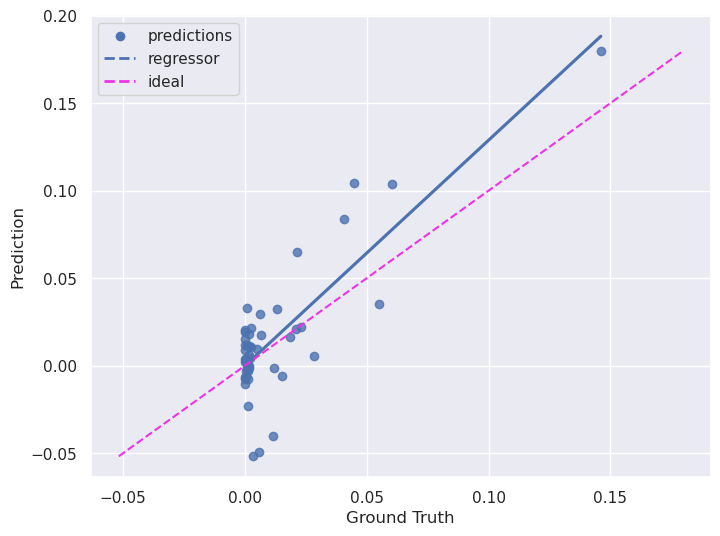

In [49]:
dfs = split_data_set(data, param_cols, SEED)
transformers_dict = {
    "x_preprocessors": [PolynomialFeatures(degree=4, interaction_only=True)],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(Lasso(max_iter=int(1e5)), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)
# save model & estimates
models['param'] = model
estimates['param'] = y_hat

## Feature-Set: Module Parameters + Log-Parameters


Average R2 Cross-Validation Score: 0.330 (± 0.543)
Average MSE Cross-Validation: -2.109e-03 (± 3.471e-03)
Validation R2 Score: 0.806
Validation MSE: 1.875e-03
Test R2 Score: 0.070
Test MSE: 5.343e-04


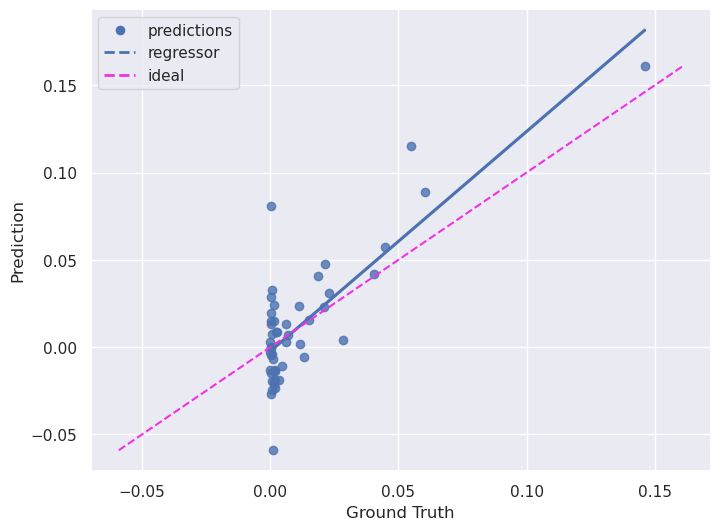

In [50]:
data_linear_with_log, param_cols_with_log = compute_log_transformed_features(data, param_cols)
dfs = split_data_set(data_linear_with_log, param_cols_with_log, SEED)
transformers_dict = {
    "x_preprocessors": [PolynomialFeatures(degree=3, interaction_only=True)],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(Lasso(max_iter=int(1e5)), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)
# save model & estimates
models['param_log_param'] = model
estimates['param_log_param'] = y_hat

## Feature-Set: MACs Only

Average R2 Cross-Validation Score: 0.970 (± 0.017)
Average MSE Cross-Validation: -1.829e-04 (± 3.735e-04)
Validation R2 Score: 0.986
Validation MSE: 1.330e-04
Test R2 Score: 0.961
Test MSE: 2.212e-05


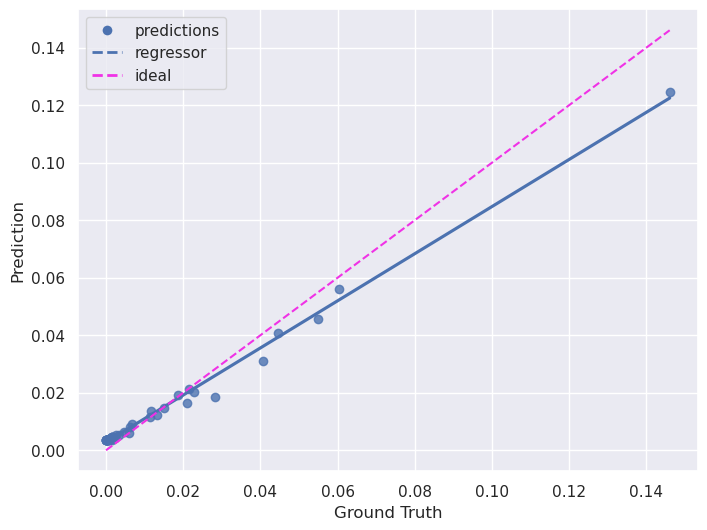

In [51]:
dfs = split_data_set(data, ['macs'], SEED)
transformers_dict = {
    "x_preprocessors": None,
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)
# save model & estimates
models['macs'] = model
estimates['macs'] = y_hat

# Feature-Set: Module Parameters + MACs

Average R2 Cross-Validation Score: 0.977 (± 0.009)
Average MSE Cross-Validation: -1.473e-04 (± 3.015e-04)
Validation R2 Score: 0.988
Validation MSE: 1.192e-04
Test R2 Score: 0.972
Test MSE: 1.612e-05


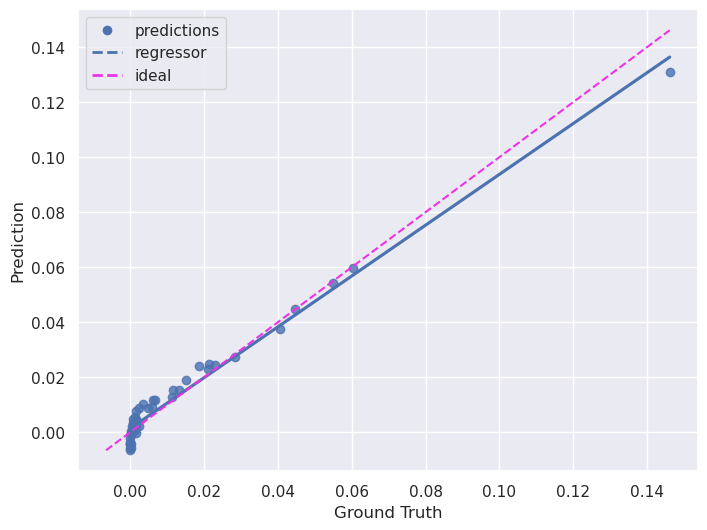

In [52]:
dfs = split_data_set(data, param_cols + ['macs'], SEED)
transformers_dict = {
    "x_preprocessors": [StandardScaler()],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)
# save model & estimates
models['param_macs'] = model
estimates['param_macs'] = y_hat

## Feature-Set: Module Parameters + Log-Parameters + MACs

Average R2 Cross-Validation Score: 0.977 (± 0.009)
Average MSE Cross-Validation: -1.422e-04 (± 2.887e-04)
Validation R2 Score: 0.988
Validation MSE: 1.125e-04
Test R2 Score: 0.969
Test MSE: 1.805e-05


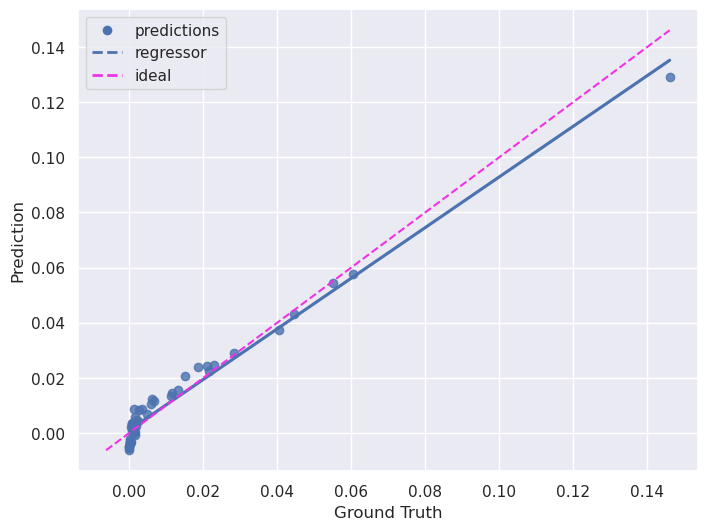

In [53]:
data_linear_with_log, param_cols_with_log = compute_log_transformed_features(data, param_cols)
dfs = split_data_set(data_linear_with_log, param_cols_with_log + ['macs'], SEED)
transformers_dict = {
    "x_preprocessors": [StandardScaler()],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)
# save model & estimates
models['param_log_param_macs'] = model
estimates['param_log_param_macs'] = y_hat

# Comparison of all models

param                               0.1
param_log_param                     0.07
macs                                0.961
param_macs                          0.972
param_log_param_macs                0.969


<Figure size 800x600 with 0 Axes>

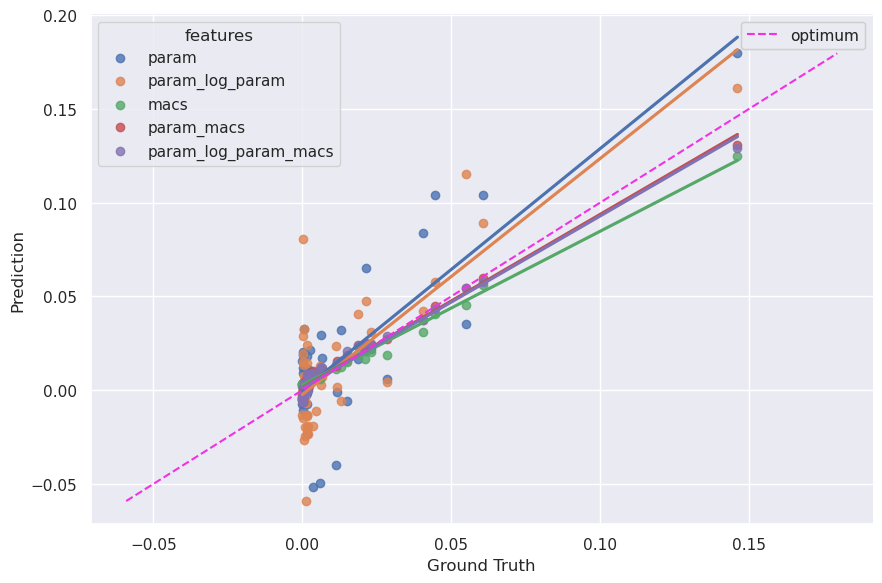

In [54]:
df_to_plot = pd.DataFrame(columns=["features","y_hat",'y'])
for model_name, model in models.items():
    new_df = pd.DataFrame(data={'features':[model_name]*len(dfs['y_test']),'y_hat':np.squeeze(estimates[model_name]),'y':np.squeeze(dfs['y_test'])})
    df_to_plot = pd.concat([df_to_plot, new_df], ignore_index=True)
    print(f"{'{:<35}'.format(model_name)} {round(r2_score(dfs['y_test'], estimates[model_name]), 3)}")
min_x = min(min(df_to_plot.y_hat),min(df_to_plot.y))
max_x = max(max(df_to_plot.y_hat),max(df_to_plot.y))
sns.set(font_scale=1)
plt.figure(figsize=(8,6))
g = sns.lmplot(data=df_to_plot, x="y", y="y_hat", hue="features", ci=None, height=6, aspect=1.5, facet_kws={'legend_out':False}, markers='o')
plt.plot([min_x, max_x], [min_x, max_x],ls='--', marker='', label='optimum', color="#f032e6")
line = Line2D([0], [0], ls='--', label='optimum', color='#f032e6')
g.set(xlabel='Ground Truth', ylabel='Prediction')
legend1 = g.legend
legend2 = plt.legend(handles = [plt.plot([],ls="--", color=line.get_color())[0]], labels=[line.get_label()], loc='best')
g.fig.add_artist(legend1)
g.fig.add_artist(legend2)